## Project: Stroke Prediction 
#### Purpose: Exploratory data analysis

## Data

The stroke data set was provided by McKinsey & Company for a hackathon event hosted by 
    Analytics Vidhya. 

## Brief Description of Variables

Total number of variables = 11

Target = stroke

Number of entries = 43400

Descrition of variables

    id = Patient ID
    gender = Gender of the patient 
    age = Patient’s age
    hypertention = Suffering from hypertension?
    heart_disease = Presence of heart disease? 
    ever_married = Ever Married?
    work_type = Type of occupation
    residence_type = Area type of resident 
    avg_glucose_level = Average glucose level after a meal
    bmi = Body mass index
    smoking_status = Smoking status
    Stroke = Has suffered or is suffering from stroke?
   

## Import modules

In [3]:
# Standard libraries
import pandas as pd
import numpy as np
import pickle

# PostgreSQL database adapter
from psycopg2 import connect

# Stratified random split of train/test data by indices
from sklearn.model_selection import StratifiedShuffleSplit

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Data Pre-Processing

In [4]:
# Set up the requirement for connecting to the database, 'patient_data' in PostgreSQL server 

params = {
    'host': '127.0.0.1',   # local host
    'port': 5432,
    'database': 'patient_data'
}

conn = connect(**params)

In [5]:
# Load the table 'stroke' into a Pandas' dataframe 
df = pd.read_sql_query('SELECT * FROM stroke', con=conn)
df.info()
# Set patients id as index as well (remove the 'id' column)
df.set_index([df.index.values,'id'], drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


## Take a quick look at the data and its missing values

In [6]:
# Size of data
df.shape

(43400, 11)

In [7]:
# Look the content in the data
df.head(5)

,,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
,id,,,,,,,,,,,
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,None,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,None,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,None,0


There are 8 nominal categorical features. The next step is to find out the in the categorical features

In [8]:
# Find out the high level information in the data, i.e., the variables' data type, sizes 
#     and check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 43400 entries, (0, 30669) to (43399, 36271)
Data columns (total 11 columns):
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(3), object(5)
memory usage: 4.6+ MB


In [9]:
# Summary statistics for each numerical variables
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


### Look into the missing data in bmi and smoking_status columns

In [10]:
# Check the number of missing observations in bmi AND smoking_status columns
df_NaN = df[df['bmi'].isnull() & df['smoking_status'].isnull()]
print(df_NaN.head(5))
print('Total # missing data = ', df_NaN.shape)
del df_NaN

           gender   age  hypertension  heart_disease ever_married work_type  \
    id                                                                        
231 22470    Male  61.0             0              0          Yes  Govt_job   
407 27419  Female  59.0             0              0          Yes   Private   
503 33723  Female   9.0             0              0           No  children   
747 8213     Male  78.0             0              1          Yes   Private   
883 809      Male  13.0             0              0           No  children   

          residence_type  avg_glucose_level  bmi smoking_status  stroke  
    id                                                                   
231 22470          Urban             184.15  NaN           None       0  
407 27419          Rural              76.15  NaN           None       1  
503 33723          Urban              95.81  NaN           None       0  
747 8213           Urban             219.84  NaN           None       1  
88

Variables bmi and smoking_status have missing values. Among them, there are 426 entries with missing values for both bmi and smoking_status features.

In [11]:
# Check the number of missing observations in bmi column
df_bmiNaN = df[df['bmi'].isnull()]
print(df_bmiNaN.head())
print('Total # missing data for bmi = ', df_bmiNaN.shape)
del df_bmiNaN

           gender   age  hypertension  heart_disease ever_married  \
    id                                                              
81  51676  Female  61.0             0              0          Yes   
95  31091    Male  34.0             0              1          Yes   
113 54312  Female  76.0             1              0          Yes   
186 11999  Female  63.0             0              0          Yes   
231 22470    Male  61.0             0              0          Yes   

               work_type residence_type  avg_glucose_level  bmi  \
    id                                                            
81  51676  Self-employed          Rural             202.21  NaN   
95  31091        Private          Urban             106.23  NaN   
113 54312  Self-employed          Urban             209.58  NaN   
186 11999       Govt_job          Rural              79.92  NaN   
231 22470       Govt_job          Urban             184.15  NaN   

            smoking_status  stroke  
    id   

There are 1462 of the 43400 observations (3.37%) are missing in the bmi column. 

In [14]:
# Check the number of missing observations in smoking_status column
df_smokingNaN = df[df['smoking_status'].isnull()]
print(df_smokingNaN.head())
print('Total # missing data for smoking_status = ', df_smokingNaN.shape)
del df_smokingNaN

          gender   age  hypertension  heart_disease ever_married  \
   id                                                              
0  30669    Male   3.0             0              0           No   
2  16523  Female   8.0             0              0           No   
4  46136    Male  14.0             0              0           No   
5  32257  Female  47.0             0              0          Yes   
10 10460  Female  79.0             0              0          Yes   

             work_type residence_type  avg_glucose_level   bmi smoking_status  \
   id                                                                           
0  30669      children          Rural              95.12  18.0           None   
2  16523       Private          Urban             110.89  17.6           None   
4  46136  Never_worked          Rural             161.28  19.1           None   
5  32257       Private          Urban             210.95  50.1           None   
10 10460      Govt_job          Urban

There are 13292 entries with missing smoking_status values. It is 30.63% (i.e. 13292/43400) of the entire dataset.

Based on the numbers of missing values in the bmi and smoking_status columns, the data can be analyzed in two ways: (1) data with smoking variable including those imputed values in the smoking_status and bmi columns; and (2) data with only patients who have never smoked but exclude any missing data for smoking_status. 

Filling the missing values in the smoking_status and bmi columns: 

* smoking_status (for (1) only): Fill up some of the missing values with "never smoked" for patients who are below age 15. This age cut-off is an assumption based on the article "At what age do kids start smoking cigarettes?[1]", which it noted that the average age of people first smoking cigarettes in U.S is 15.3 (See the plot in the cell below).

* bmi (for (1) and (2)): The missing values are replace with the median or mean value. 

reference: 
[1] "At what age do kids start smoking cigarettes?" retrieve from https://www.cnn.com/2018/08/22/health/cigarette-smoking-teens-parent-curve-intl/index.html

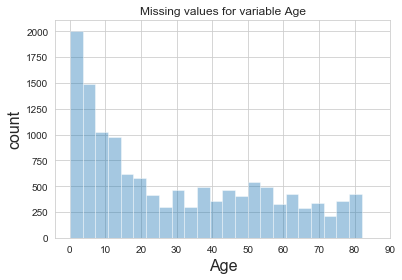

Total # under aged 15 =  5499


In [45]:
# Plot the age distribution for the missing observations in smoking_status columns
df_temp = df[df['smoking_status'].isnull()]
sns.distplot(df_temp['age'], kde=False, norm_hist=False)
plt.xticks([x for x in range(0,100,10)])
plt.xlabel('Age', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.title('Missing values for variable Age')
plt.show()
print('Total # under aged 15 = ', len(df_temp[df_temp['age'] < 15]))
del df_temp

This plot shows the large portion of missing data for smoking are found in patients younger than 15 years old. Assuming patients aged under 15 don't smoke, the 5499 missing observations are replaced with "never_smoked". 

In [16]:
df_temp = df[(df['smoking_status']=="never smoked") & (df['stroke']==1)]
print(df_temp.head(5))
print('Total # data = ', df_temp.shape)
del df_temp
# Never smoke only has (16053, 11)
# Never smoke and stroke = (284, 11)

           gender   age  hypertension  heart_disease ever_married  \
    id                                                              
81  51676  Female  61.0             0              0          Yes   
141 31112    Male  80.0             0              1          Yes   
264 1665   Female  79.0             1              0          Yes   
291 53882    Male  74.0             1              1          Yes   
320 10434  Female  69.0             0              0           No   

               work_type residence_type  avg_glucose_level   bmi  \
    id                                                             
81  51676  Self-employed          Rural             202.21   NaN   
141 31112        Private          Rural             105.92  32.5   
264 1665   Self-employed          Rural             174.12  24.0   
291 53882        Private          Rural              70.09  27.4   
320 10434        Private          Urban              94.39  22.8   

          smoking_status  stroke  
    

## Create training and test sets
The test data are set aside. Only the training data sets will be explored and analyzed.

In [17]:
# Stratified sampling based on 'stroke' variable
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=10)

for train_index, test_index in split.split(df, df['stroke']):
    df_strat_train = df.loc[train_index]
    df_strat_test = df.loc[test_index]

In [18]:
df_strat_train.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [19]:
df_strat_test.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [20]:
# First training and test sets (data include smoking_status)
df_strat_train_smoke = df_strat_train.drop(df_strat_train[(df_strat_train['smoking_status'].isnull()) & (df_strat_train['age'] >= 15)].index)
df_strat_test_smoke = df_strat_test.drop(df_strat_test[(df_strat_test['smoking_status'].isnull()) & (df_strat_test['age'] >= 15)].index)


In [21]:
# Second training and test sets (data with patients who have never smoked)
df_strat_train_neversmoke = df_strat_train[(df_strat_train['smoking_status']=='never smoked')]
df_strat_test_neversmoke = df_strat_test[(df_strat_test['smoking_status']=='never smoked')]

In [22]:
del df_strat_train
del df_strat_test

## Explore and visualize the training data sets

In [23]:
# Set all the plots' style
sns.set_style("whitegrid")

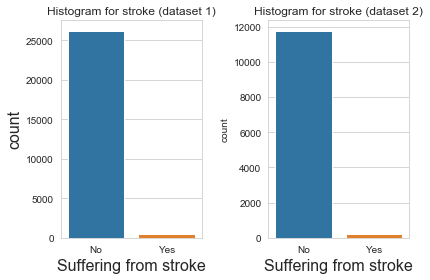


target: stroke (With smoking status)
0    26208
1      479
Name: stroke, dtype: int64 0    0.982051
1    0.017949
Name: stroke, dtype: float64

target: stroke (Patients who have never smoked)
0    11779
1      214
Name: stroke, dtype: int64 0    0.982156
1    0.017844
Name: stroke, dtype: float64


In [43]:
# Find out more about the target variable
    # Plot the class distrbution of the stroke data
f, axes = plt.subplots(1,2)
sns.countplot(x='stroke', data=df_strat_train_smoke, ax=axes[0])
sns.countplot(x='stroke', data=df_strat_train_neversmoke, ax=axes[1])
axes[0].set_title('Histogram for stroke (dataset 1)')
axes[1].set_title('Histogram for stroke (dataset 2)')
axes[0].set_xticklabels(['No','Yes'])
axes[1].set_xticklabels(['No','Yes'])
axes[0].set_xlabel('Suffering from stroke', fontsize=16)
axes[1].set_xlabel('Suffering from stroke', fontsize=16)
axes[0].set_ylabel('count', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=4)
plt.show()
print('\ntarget: stroke (With smoking status)')
print(df_strat_train_smoke['stroke'].value_counts()
, df_strat_train_smoke['stroke'].value_counts(normalize=True))

print('\ntarget: stroke (Patients who have never smoked)')
print(df_strat_train_neversmoke['stroke'].value_counts(), df_strat_train_neversmoke['stroke'].value_counts(normalize=True))


The percentage of patients who haven't had a stroke is around 98.2%. This is a obvious case of class imbalance.

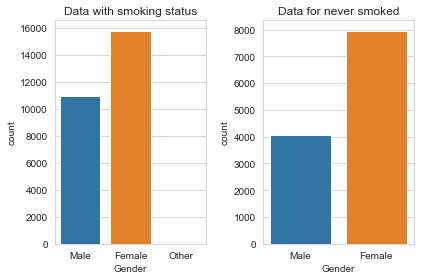


feature: gender (With smoking status)
Female    15761
Male      10919
Other         7
Name: gender, dtype: int64

feature: gender (Patients who have never smoked)
Female    7941
Male      4052
Name: gender, dtype: int64


In [25]:
# Find out more about the catagorical features
    #https://seaborn.pydata.org/tutorial/categorical.html
    # Plot the distribution of gender
f, axes = plt.subplots(1,2)
sns.countplot(x='gender', data=df_strat_train_smoke, ax=axes[0])
sns.countplot(x='gender', data=df_strat_train_neversmoke, ax=axes[1])
axes[0].set_title('Data with smoking status')
axes[1].set_title('Data for never smoked')
axes[0].set_xlabel('Gender')
axes[1].set_xlabel('Gender')
axes[0].set_ylabel('count')
plt.tight_layout()
plt.subplots_adjust(hspace=4)
plt.show()

print('\nfeature: gender (With smoking status)')
print(df_strat_train_smoke['gender'].value_counts())

print('\nfeature: gender (Patients who have never smoked)')
print(df_strat_train_neversmoke['gender'].value_counts())

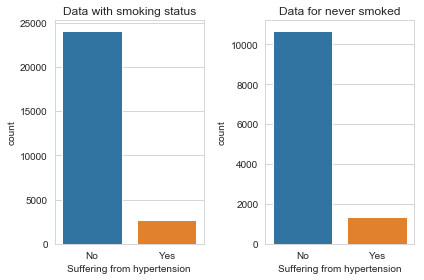


feature: hypertension (With smoking status)
0    24034
1     2653
Name: hypertension, dtype: int64

feature: hypertension (Patients who have never smoked)
0    10665
1     1328
Name: hypertension, dtype: int64


In [26]:
# Find out more about the catagorical features
    # Plot the distribution of hypertension
f, axes = plt.subplots(1,2)
sns.countplot(x='hypertension', data=df_strat_train_smoke, ax=axes[0])
sns.countplot(x='hypertension', data=df_strat_train_neversmoke, ax=axes[1])
axes[0].set_title('Data with smoking status')
axes[1].set_title('Data for never smoked')
axes[0].set_xticklabels(['No','Yes'])
axes[1].set_xticklabels(['No','Yes'])
axes[0].set_xlabel('Suffering from hypertension')
axes[1].set_xlabel('Suffering from hypertension')
axes[0].set_ylabel('count')
plt.tight_layout()
plt.subplots_adjust(hspace=4)
plt.show()

print('\nfeature: hypertension (With smoking status)')
print(df_strat_train_smoke['hypertension'].value_counts())

print('\nfeature: hypertension (Patients who have never smoked)')
print(df_strat_train_neversmoke['hypertension'].value_counts())

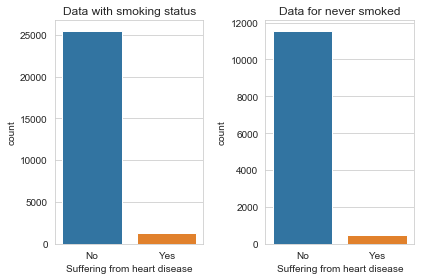


feature: heart_disease (With smoking status)
0    25440
1     1247
Name: heart_disease, dtype: int64

feature: heart_disease (Patients who have never smoked)
0    11541
1      452
Name: heart_disease, dtype: int64


In [27]:
# Find out more about the catagorical features
    # Plot the distribution of heart disease
f, axes = plt.subplots(1,2)
sns.countplot(x='heart_disease', data=df_strat_train_smoke, ax=axes[0])
sns.countplot(x='heart_disease', data=df_strat_train_neversmoke, ax=axes[1])
axes[0].set_title('Data with smoking status')
axes[1].set_title('Data for never smoked')
axes[0].set_xticklabels(['No','Yes'])
axes[1].set_xticklabels(['No','Yes'])
axes[0].set_xlabel('Suffering from heart disease')
axes[1].set_xlabel('Suffering from heart disease')
axes[0].set_ylabel('count')
plt.tight_layout()
plt.subplots_adjust(hspace=4)
plt.show()

print('\nfeature: heart_disease (With smoking status)')
print(df_strat_train_smoke['heart_disease'].value_counts())

print('\nfeature: heart_disease (Patients who have never smoked)')
print(df_strat_train_neversmoke['heart_disease'].value_counts())

The remaining 790+ cases (1247-452) are thre result of smoking cigarettes.

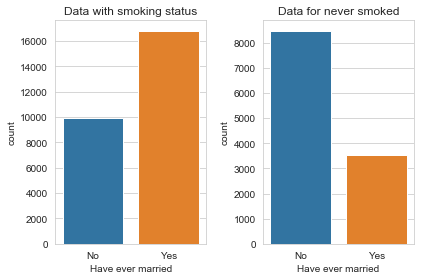


feature: ever_married (With smoking status)
Yes    16783
No      9904
Name: ever_married, dtype: int64

feature: ever_married (Patients who have never smoked)
Yes    8461
No     3532
Name: ever_married, dtype: int64


In [28]:
# Find out more about the catagorical features
    # Plot the distribution of ever_married
f, axes = plt.subplots(1,2)
sns.countplot(x='ever_married', data=df_strat_train_smoke, ax=axes[0])
sns.countplot(x='ever_married', data=df_strat_train_neversmoke, ax=axes[1])
axes[0].set_title('Data with smoking status')
axes[1].set_title('Data for never smoked')
axes[0].set_xticklabels(['No','Yes'])
axes[1].set_xticklabels(['No','Yes'])
axes[0].set_xlabel('Have ever married')
axes[1].set_xlabel('Have ever married')
axes[0].set_ylabel('count')
plt.tight_layout()
plt.subplots_adjust(hspace=4)
plt.show()

print('\nfeature: ever_married (With smoking status)')
print(df_strat_train_smoke['ever_married'].value_counts())

print('\nfeature: ever_married (Patients who have never smoked)')
print(df_strat_train_neversmoke['ever_married'].value_counts())

The plots may be suggesting specific dominant feature(s) in the data with patients who have never smoke. 

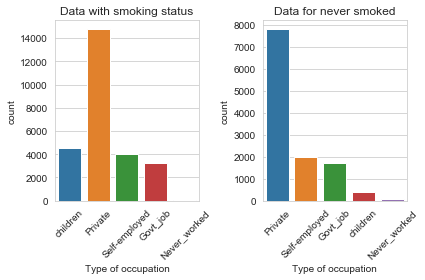


feature: work_type (With smoking status)
Private          14777
children          4519
Self-employed     4031
Govt_job          3278
Never_worked        82
Name: work_type, dtype: int64

feature: work_type (Patients who have never smoked)
Private          7814
Self-employed    2006
Govt_job         1735
children          380
Never_worked       58
Name: work_type, dtype: int64


In [29]:
# Find out more about the catagorical features
    # Plot the distribution of work_type
f, axes = plt.subplots(1,2)
sns.countplot(x='work_type', data=df_strat_train_smoke, ax=axes[0])
sns.countplot(x='work_type', data=df_strat_train_neversmoke, ax=axes[1])
axes[0].set_title('Data with smoking status')
axes[1].set_title('Data for never smoked')
axes[0].set_xlabel('Type of occupation')
axes[1].set_xlabel('Type of occupation')
axes[0].set_ylabel('count')
for tick in axes[0].get_xticklabels():
    tick.set_rotation(45)
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)    
plt.tight_layout()
plt.subplots_adjust(hspace=4)
plt.show()

print('\nfeature: work_type (With smoking status)')
print(df_strat_train_smoke['work_type'].value_counts())

print('\nfeature: work_type (Patients who have never smoked)')
print(df_strat_train_neversmoke['work_type'].value_counts())

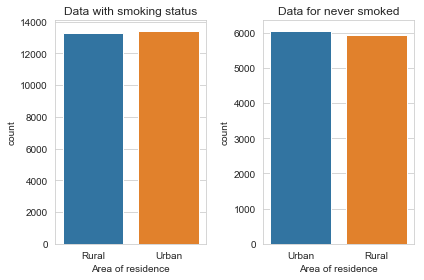


feature: Residence_type (With smoking status)
Urban    13401
Rural    13286
Name: residence_type, dtype: int64

feature: Residence_type (Patients who have never smoked)
Urban    6046
Rural    5947
Name: residence_type, dtype: int64


In [30]:
# Find out more about the catagorical features
    # Plot the distribution of Residence_type
f, axes = plt.subplots(1,2)
sns.countplot(x='residence_type', data=df_strat_train_smoke, ax=axes[0])
sns.countplot(x='residence_type', data=df_strat_train_neversmoke, ax=axes[1])
axes[0].set_title('Data with smoking status')
axes[1].set_title('Data for never smoked')
axes[0].set_xlabel('Area of residence')
axes[1].set_xlabel('Area of residence')
axes[0].set_ylabel('count') 
plt.tight_layout()
plt.subplots_adjust(hspace=4)
plt.show()


print('\nfeature: Residence_type (With smoking status)')
print(df_strat_train_smoke['residence_type'].value_counts())

print('\nfeature: Residence_type (Patients who have never smoked)')
print(df_strat_train_neversmoke['residence_type'].value_counts())

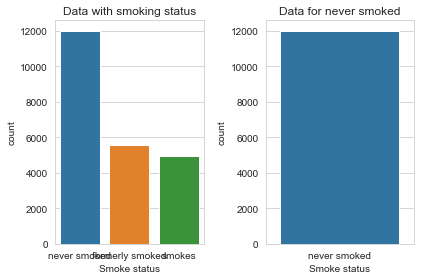


feature: smoking_status (With smoking status)
never smoked       11993
formerly smoked     5594
smokes              4939
Name: smoking_status, dtype: int64

feature: smoking_status (Patients who have never smoked)
never smoked    11993
Name: smoking_status, dtype: int64


In [31]:
# Find out more about the catagorical features
    # Plot the distribution of smoking_status
f, axes = plt.subplots(1,2)
sns.countplot(x='smoking_status', data=df_strat_train_smoke, ax=axes[0])
sns.countplot(x='smoking_status', data=df_strat_train_neversmoke, ax=axes[1])
axes[0].set_title('Data with smoking status')
axes[1].set_title('Data for never smoked')
axes[0].set_xlabel('Smoke status')
axes[1].set_xlabel('Smoke status')
axes[0].set_ylabel('count') 
plt.tight_layout()
plt.subplots_adjust(hspace=4)
plt.show()

print('\nfeature: smoking_status (With smoking status)')
print(df_strat_train_smoke['smoking_status'].value_counts())

print('\nfeature: smoking_status (Patients who have never smoked)')
print(df_strat_train_neversmoke['smoking_status'].value_counts())

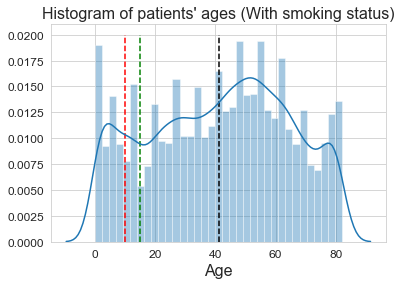


feature: age (With smoking status)
count    26687.000000
mean        41.305142
std         22.999579
min          0.080000
25%         23.000000
50%         43.000000
75%         59.000000
max         82.000000
Name: age, dtype: float64


In [32]:
# Find out the summary in the numerical features.
    # Plot the distribution of age (tried several bin sizes. The default bins=40 is the best)
sns.distplot(df_strat_train_smoke['age'])
plt.vlines(round(df_strat_train_smoke['age'].mean(),2), 0, 0.02, colors='k', linestyles='dashed')
plt.vlines(10, 0, 0.02, colors='r', linestyles='dashed')
plt.vlines(15, 0, 0.02, colors='g', linestyles='dashed')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Histogram of patients' ages (With smoking status)", fontsize=16)
plt.xlabel('Age', fontsize=16)
plt.show()
#print('Number of children below 15 years old = ', df[df['age'] < 15].shape)
#print('Number of children below 17 years old = ', df[df['age'] < 17].shape)
print('\nfeature: age (With smoking status)')
print(df_strat_train_smoke['age'].describe())


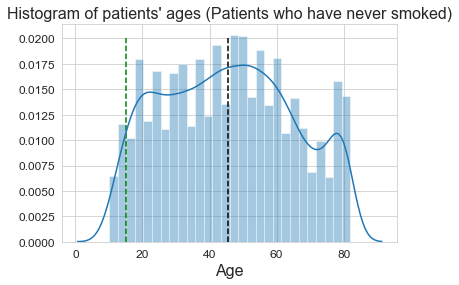


feature: age (Patients who have never smoked)
count    11993.000000
mean        45.591929
std         19.303423
min         10.000000
25%         30.000000
50%         45.000000
75%         60.000000
max         82.000000
Name: age, dtype: float64


In [33]:
# Find out the summary in the numerical features.
    # Plot the distribution of age (tried several bin sizes. The default bins=40 is the best)
sns.distplot(df_strat_train_neversmoke['age'])
plt.vlines(round(df_strat_train_neversmoke['age'].mean(),2), 0, 0.02, colors='k', linestyles='dashed')
plt.vlines(15, 0, 0.02, colors='g', linestyles='dashed')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Histogram of patients' ages (Patients who have never smoked)", fontsize=16)
plt.xlabel('Age', fontsize=16)
plt.show()
#print('Number of children below 15 years old = ', df[df['age'] < 15].shape)
#print('Number of children below 17 years old = ', df[df['age'] < 17].shape)
print('\nfeature: age (Patients who have never smoked)')
print(df_strat_train_neversmoke['age'].describe())

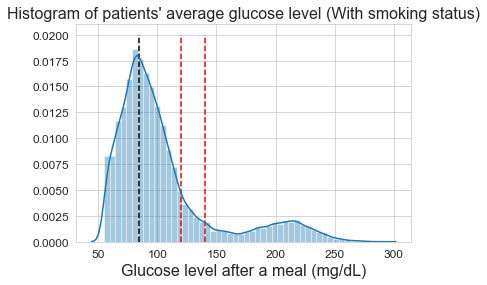

Mode of avg_glucose_level =  0    84.49
dtype: float64

feature: avg_glucose_level (With smoking status)
count    26687.000000
mean       104.688668
std         43.482063
min         55.000000
25%         77.500000
50%         91.600000
75%        112.160000
max        291.050000
Name: avg_glucose_level, dtype: float64


In [34]:
# Find out the summary in the numerical features.
    # Plot the distribution of avg_glucose_level
sns.distplot(df_strat_train_smoke['avg_glucose_level'])
plt.vlines(round(df_strat_train_smoke['avg_glucose_level'].mode(),2), 0, 0.02, colors='k', linestyles='dashed')
plt.vlines(120, 0, 0.02, colors='r', linestyles='dashed')
plt.vlines(140, 0, 0.02, colors='r', linestyles='dashed')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Histogram of patients' average glucose level (With smoking status)", fontsize=16)
plt.xlabel('Glucose level after a meal (mg/dL)', fontsize=16)
plt.show()
print('Mode of avg_glucose_level = ', df_strat_train_smoke['avg_glucose_level'].mode())

print('\nfeature: avg_glucose_level (With smoking status)')
print(df_strat_train_smoke['avg_glucose_level'].describe())

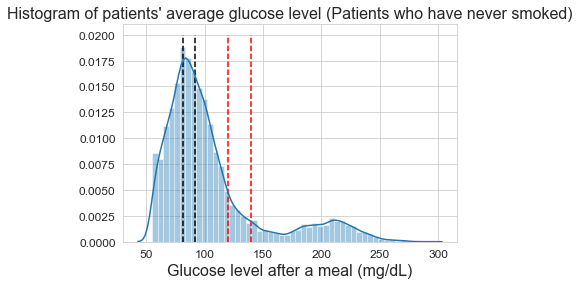

Mode of avg_glucose_level =  0    81.41
1    91.57
dtype: float64

feature: avg_glucose_level (Patients who have never smoked)
count    11993.000000
mean       104.879254
std         43.406337
min         55.010000
25%         77.790000
50%         91.850000
75%        112.260000
max        291.050000
Name: avg_glucose_level, dtype: float64


In [35]:
# Find out the summary in the numerical features.
    # Plot the distribution of avg_glucose_level
sns.distplot(df_strat_train_neversmoke['avg_glucose_level'])
plt.vlines(round(df_strat_train_neversmoke['avg_glucose_level'].mode(),2), 0, 0.02, colors='k', linestyles='dashed')
plt.vlines(120, 0, 0.02, colors='r', linestyles='dashed')
plt.vlines(140, 0, 0.02, colors='r', linestyles='dashed')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Histogram of patients' average glucose level (Patients who have never smoked)", fontsize=16)
plt.xlabel('Glucose level after a meal (mg/dL)', fontsize=16)
plt.show()
print('Mode of avg_glucose_level = ', df_strat_train_neversmoke['avg_glucose_level'].mode())

print('\nfeature: avg_glucose_level (Patients who have never smoked)')
print(df_strat_train_neversmoke['avg_glucose_level'].describe())


The red lines indicates the normal glucose level (120-140 mg/dL) 2 hours after a meal. Patients with glucose level within 140 to 200 are at the prediabetic condition. Any level that is 200 or more is an indication that the patient is diagnosed with diabetes.

Reference: https://diabetesaction.org/questions-blood-sugar

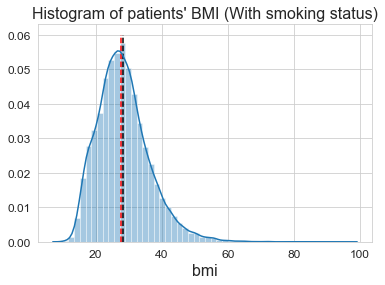


feature: bmi (With smoking status)
count    25864.000000
mean        28.377227
std          7.840160
min         10.100000
25%         22.900000
50%         27.600000
75%         32.700000
max         96.100000
Name: bmi, dtype: float64


In [36]:
# Find out the summary in the numerical features.
    # Plot the distribution of bmi
sns.distplot(df_strat_train_smoke['bmi'].dropna(axis=0))
plt.vlines(round(df_strat_train_smoke['bmi'].mean(),2), 0, 0.06, colors='k', linestyles='dashed')
plt.vlines(round(df_strat_train_smoke['bmi'].median(),2), 0, 0.06, colors='r', linestyles='dashed')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Histogram of patients' BMI (With smoking status)", fontsize=16)
plt.xlabel('bmi',fontsize=16)
plt.show()

print('\nfeature: bmi (With smoking status)')
print(df_strat_train_smoke['bmi'].describe())

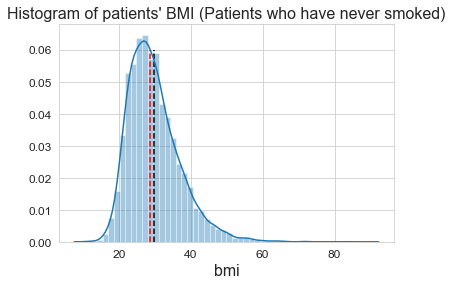


feature: bmi (Patients who have never smoked)
count    11763.00000
mean        29.77385
std          7.19718
min         10.80000
25%         24.60000
50%         28.60000
75%         33.60000
max         89.00000
Name: bmi, dtype: float64


In [37]:
# Find out the summary in the numerical features.
    # Plot the distribution of bmi
sns.distplot(df_strat_train_neversmoke['bmi'].dropna(axis=0))
plt.vlines(round(df_strat_train_neversmoke['bmi'].mean(),2), 0, 0.06, colors='k', linestyles='dashed')
plt.vlines(round(df_strat_train_neversmoke['bmi'].median(),2), 0, 0.06, colors='r', linestyles='dashed')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Histogram of patients' BMI (Patients who have never smoked)", fontsize=16)
plt.xlabel('bmi',fontsize=16)
plt.show()

print('\nfeature: bmi (Patients who have never smoked)')
print(df_strat_train_neversmoke['bmi'].describe())


/Applications/Research/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Applications/Research/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Applications/Research/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Applications/Research/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Applications/Research/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encounter

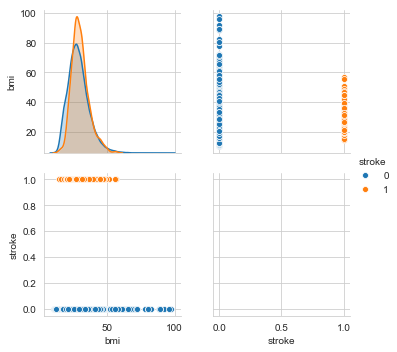

In [38]:
df_temp = pd.DataFrame()
df_temp['bmi'] = df['bmi']
df_temp['stroke'] = df['stroke']
df_temp.dropna()
df_temp.head()
sns.pairplot(df_temp, hue='stroke')
del df_temp

## Data Cleaning

In [39]:
# Handle the missing values in the bmi feature
#     Replace the missing values with median instead of mean to handle future skewed data
#     If the distribution isn't skewed, the bmi's mean and median should be close

# Data set1
df_strat_train_smoke['smoking_status'].fillna('never smoked', inplace=True)
df_strat_test_smoke['smoking_status'].fillna('never smoked', inplace=True)
train_smoke_median = df_strat_train_smoke['bmi'].median()
df_strat_train_smoke['bmi'].fillna(train_smoke_median, inplace=True)
df_strat_test_smoke['bmi'].fillna(train_smoke_median, inplace=True)


In [40]:
"""
# Use sklearn's SimpleImputer: Content in the dataframe must be numetric. So, has to convert the categorical
#    variables to dummy variables first
train_smoke_median_imputer = SimpleImputer(strategy='median')
train_smoke_median_imputer.fit(df_strat_train_smoke.values)
X = train_smoke_median_imputer.transform(df_strat_train_smoke)
col_names = df_strat_train_smoke.columns
X = pd.DataFrame(X, columns=col_names)
"""

"\n# Use sklearn's SimpleImputer: Content in the dataframe must be numetric. So, has to convert the categorical\n#    variables to dummy variables first\ntrain_smoke_median_imputer = SimpleImputer(strategy='median')\ntrain_smoke_median_imputer.fit(df_strat_train_smoke.values)\nX = train_smoke_median_imputer.transform(df_strat_train_smoke)\ncol_names = df_strat_train_smoke.columns\nX = pd.DataFrame(X, columns=col_names)\n"

In [41]:
# Data set2
df_strat_train_neversmoke.drop(columns=['smoking_status'], inplace=True)
df_strat_test_neversmoke.drop(columns=['smoking_status'], inplace=True)
train_neversmoke_median = df_strat_train_neversmoke['bmi'].median()
df_strat_train_neversmoke['bmi'].fillna(train_neversmoke_median, inplace=True)
df_strat_test_neversmoke['bmi'].fillna(train_neversmoke_median, inplace=True)


In [42]:
# Pickle the training and test data sets
#   They are located in data/processed folder
"""
with open('df_strat_train_smoke_clean.pickle', 'wb') as write_to:
    pickle.dump(df_strat_train_smoke, write_to)

with open('df_strat_test_smoke_clean.pickle', 'wb') as write_to:
    pickle.dump(df_strat_test_smoke, write_to)
    
with open('df_strat_train_neversmoke_clean.pickle', 'wb') as write_to:
    pickle.dump(df_strat_train_neversmoke, write_to)
    
with open('df_strat_test_neversmoke_clean.pickle', 'wb') as write_to:
    pickle.dump(df_strat_test_neversmoke, write_to)
"""

"\nwith open('df_strat_train_smoke_clean.pickle', 'wb') as write_to:\n    pickle.dump(df_strat_train_smoke, write_to)\n\nwith open('df_strat_test_smoke_clean.pickle', 'wb') as write_to:\n    pickle.dump(df_strat_test_smoke, write_to)\n    \nwith open('df_strat_train_neversmoke_clean.pickle', 'wb') as write_to:\n    pickle.dump(df_strat_train_neversmoke, write_to)\n    \nwith open('df_strat_test_neversmoke_clean.pickle', 'wb') as write_to:\n    pickle.dump(df_strat_test_neversmoke, write_to)\n"